# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

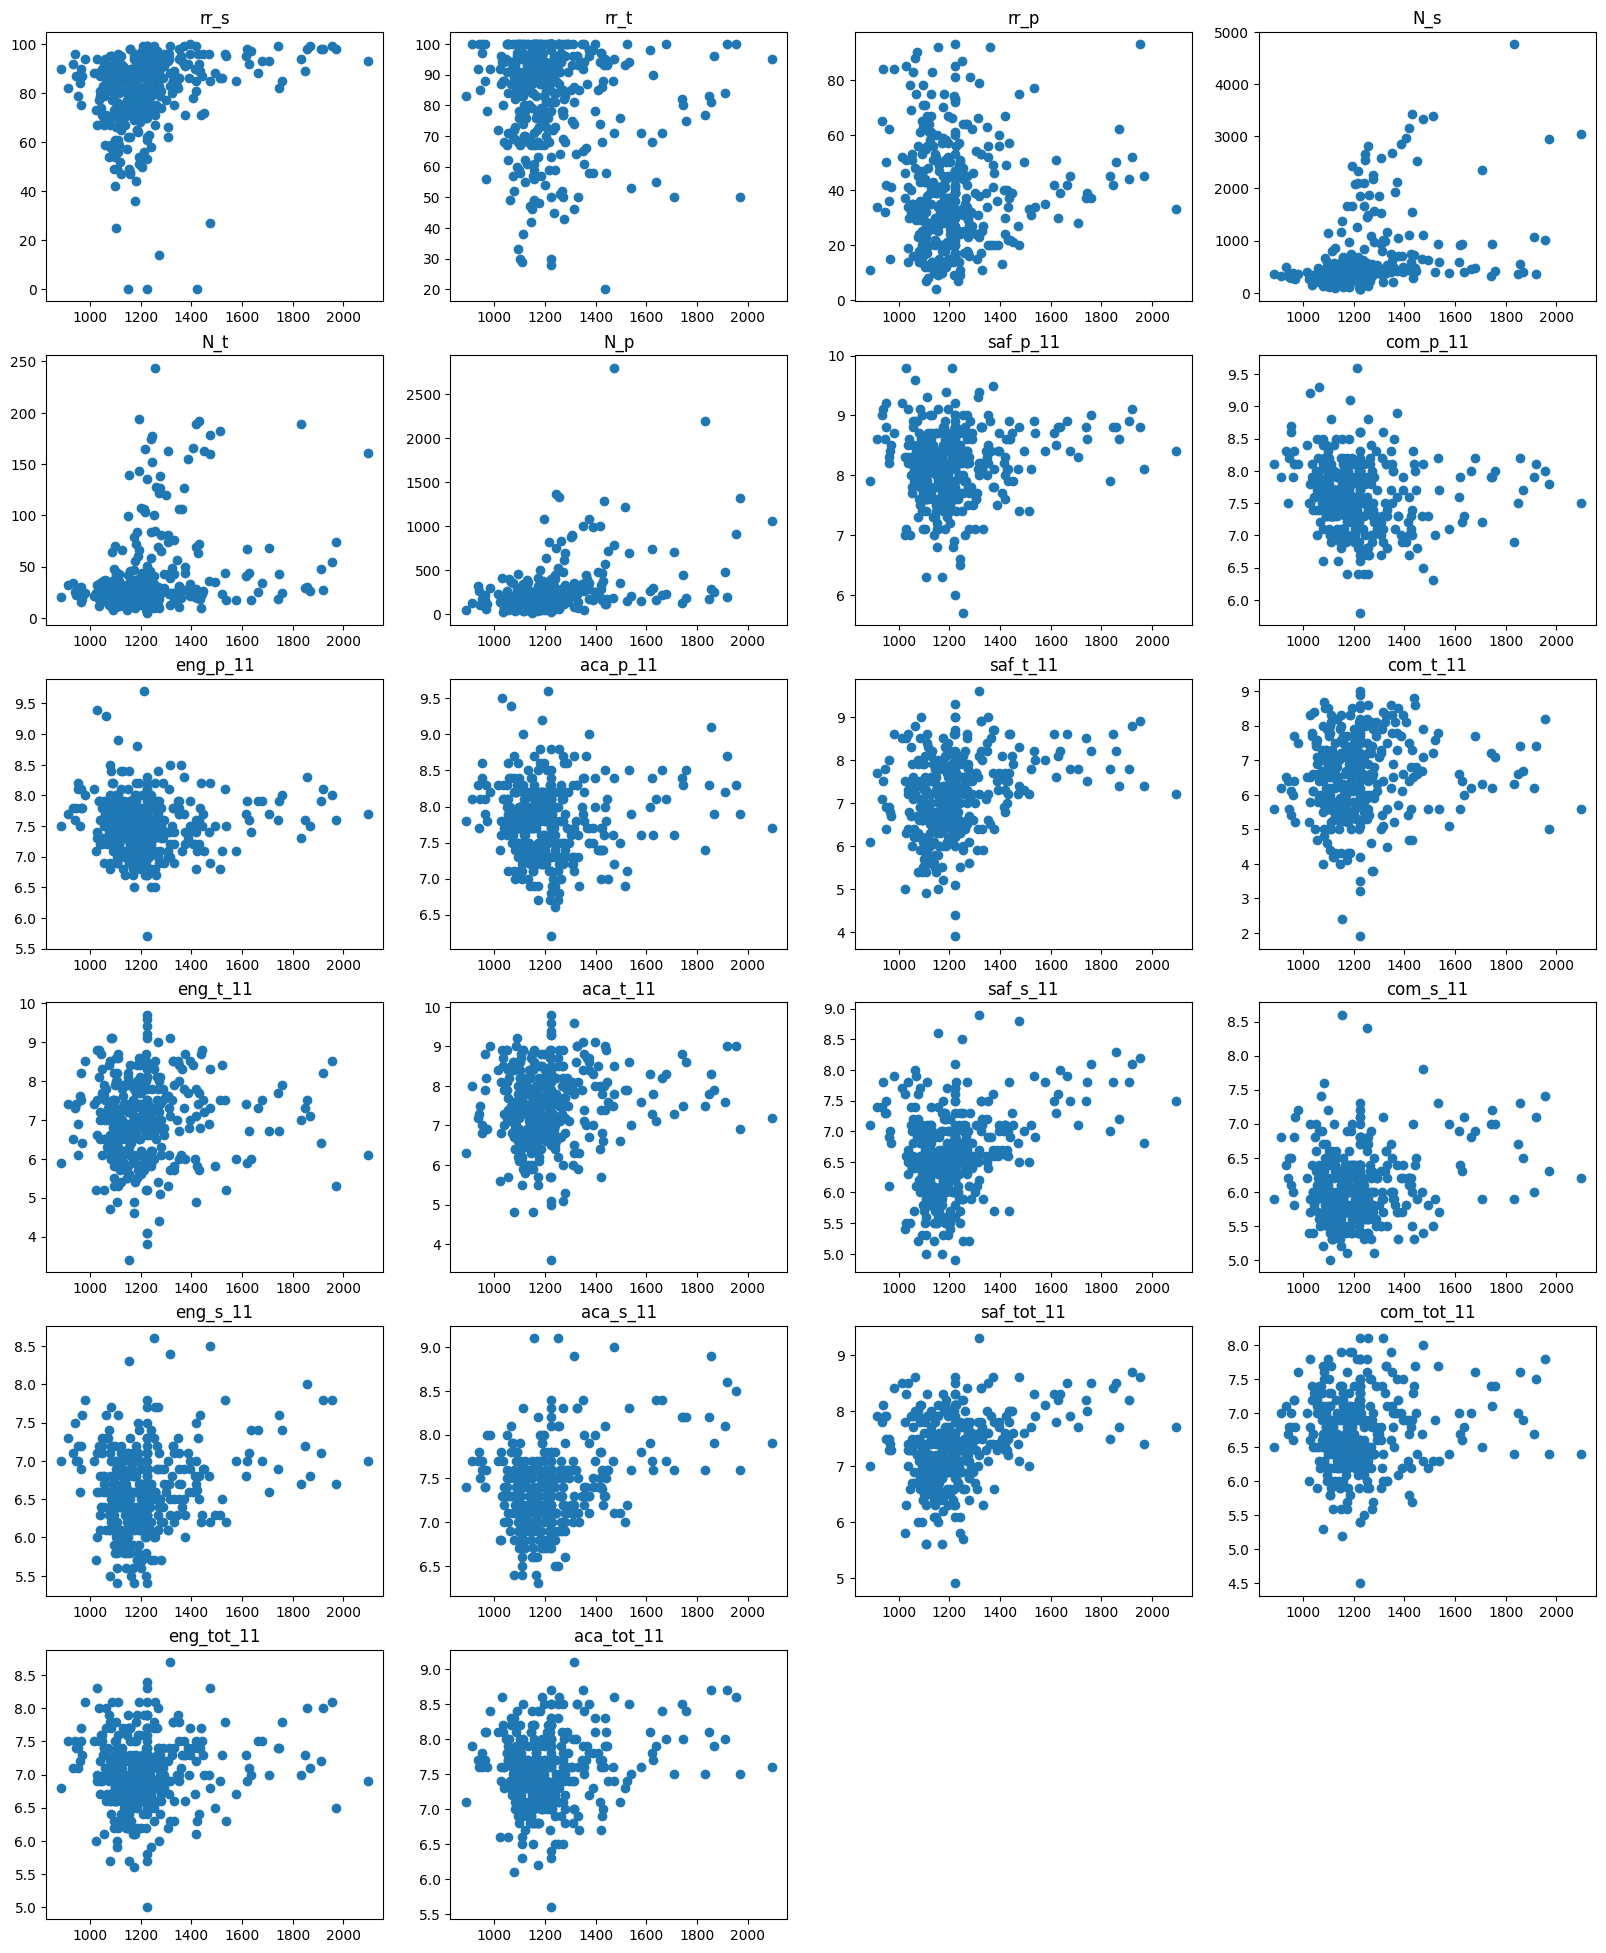

In [12]:
%matplotlib inline
plt.figure(figsize=(20,25))
i = 1
for c in survey_fields:
    plt.subplot(6, 4, i)
    plt.scatter(combined['sat_score'], combined[c])
    plt.title(c)
    i = i+1

plt.show()

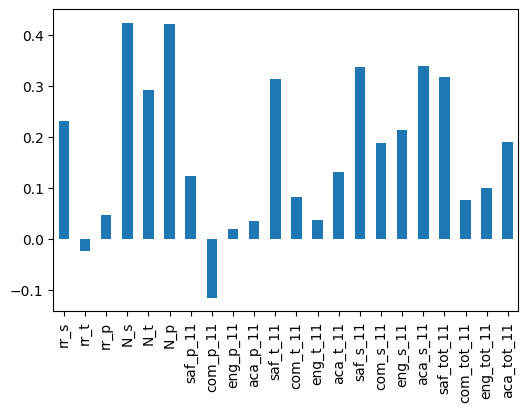

In [13]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are several notable results:
* The larger the number of respondents, the higher the average SAT score was for that school
    * This makes sense as these are most liklely highly positively correlated with total enrollment
* Schools who scored a lower communication score from a parent's point of view, on average had a lower SAT score
    * This may be due to it being an anomaly as the other parent scoring had very little correlation with the SAT score
* It seems student's scoring of the school seem to have a bigger impact on the SAT score
* Overall safety seems to be the mostly correlated with the SAT score of the school

# Investigating Safety Scores

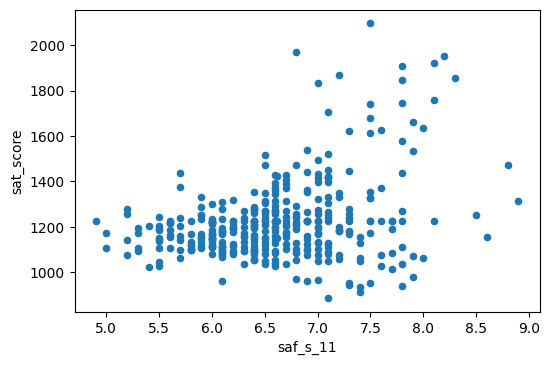

In [14]:
%matplotlib inline
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

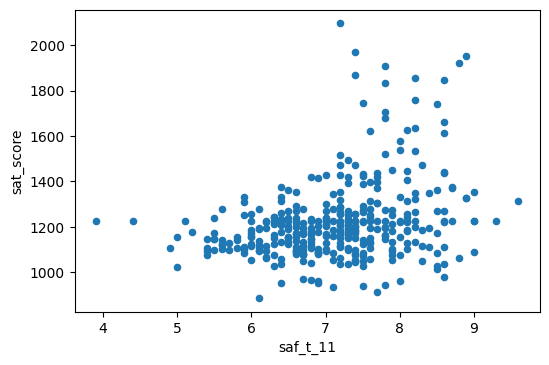

In [15]:
%matplotlib inline
combined.plot.scatter(x = 'saf_t_11', y = 'sat_score')

It is apparently that there is a slight positive correlation

There is a diverging correlation between the safety score and the sat score

# Safety Score by Region

In [16]:
combined.groupby('boro').agg(np.mean)[["saf_s_11",'saf_t_11']]

,saf_s_11,saf_t_11
boro,,
Bronx,6.606577,7.026882
Brooklyn,6.370755,6.985849
Manhattan,6.831370,7.287778
Queens,6.721875,7.365625
Staten Island,6.530000,7.210000


Interestingly, students felt that on average the safety scores were lower compared to what the teacher scored

Brooklyn is the least safest region whilst Manhattan and Queens scored the highest.

# Race & SAT Scores

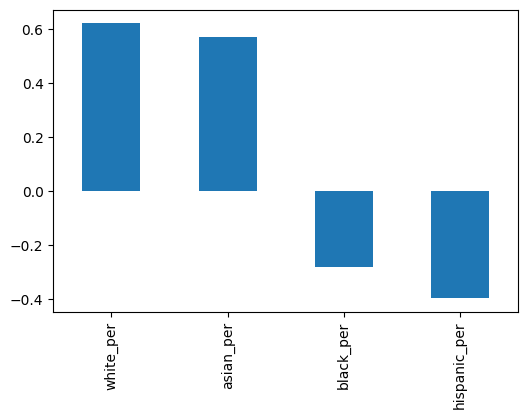

In [17]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][race_cols].plot.bar()

Asians and White race kids scored higher SAT scores compared to other racial counterparts (i.e. Black and Hispanic)

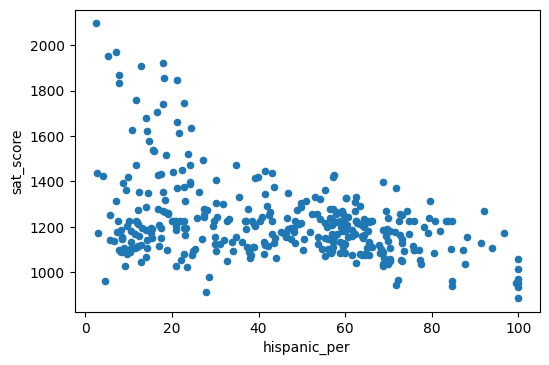

In [18]:
%matplotlib inline
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

There seems to be a fairly strong correlation between SAT score and the percentage of hispanics. The correlation seems to be diverging, so the larger the concentration of hispanics, the stronger predictor it is of SAT score. 

In [19]:
mask = combined['hispanic_per']>95
combined[mask]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


These all seem to be some form of specialised schools geared towards immigrants for example being international schools and also language schools. 

Manhattan and Bronx seem to be the popular regions with majority hispanics

In [20]:
mask_2 = (combined['hispanic_per']<10)
combined[mask_2]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.000000,735.000000,682.000000,2096.000000,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.000000,581.000000,431.000000,1424.000000,High School for Dual Language and Asian Studies,61.000000,96.000000,...,0,0,0,0.0,0.0,0.0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.000000,688.000000,649.000000,1969.000000,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.000000,659.000000,587.000000,1833.000000,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
192,13K595,BEDFORD ACADEMY HIGH SCHOOL,89,438.000000,443.000000,431.000000,1312.000000,Bedford Academy High School,43.000000,57.000000,...,0,0,0,0.0,0.0,0.0,"1119 Bedford Avenue\nBrooklyn, NY 11216\n(40.6...",40.685381,-73.954268,13
194,13K670,BENJAMIN BANNEKER ACADEMY,185,471.000000,472.000000,448.000000,1391.000000,BENJAMIN BANNEKER ACADEMY,132.000000,149.000000,...,0,0,0,0.0,0.0,0.0,"71-77 Clinton Avenue\nBrooklyn, NY 11205\n(40....",40.695662,-73.969286,13
220,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365.000000,370.000000,362.000000,1097.000000,BOYS AND GIRLS HS,22.000000,32.000000,...,0,0,0,0.0,0.0,0.0,"1700 Fulton Street\nBrooklyn, NY 11213\n(40.67...",40.679433,-73.932432,16
223,17K382,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,59,396.000000,374.000000,369.000000,1139.000000,Academy for College Preparation and Career Exp...,64.000000,82.000000,...,0,0,0,0.0,0.0,0.0,"911 Flatbush Avenue\nBrooklyn, NY 11226\n(40.6...",40.649440,-73.958431,17
226,17K528,THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP,46,403.000000,385.000000,388.000000,1176.000000,"High School for Global Citizenship, The",20.000000,34.000000,...,0,0,0,0.0,0.0,0.0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648,17
227,17K531,"SCHOOL FOR HUMAN RIGHTS, THE",35,348.000000,381.000000,359.000000,1088.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"600 Kingston Avenue\nBrooklyn, NY 11203\n(40.6...",40.659517,-73.942546,17


These schools seem to be very highly regarded schools who may potentially get extra funding for being academys/specialised in a specific subject. 

This might seem to suggest that funding may be a cause of hispanic concentrated school to be underperforming in SATs but would require investigation.

# Gender and SAT Scores

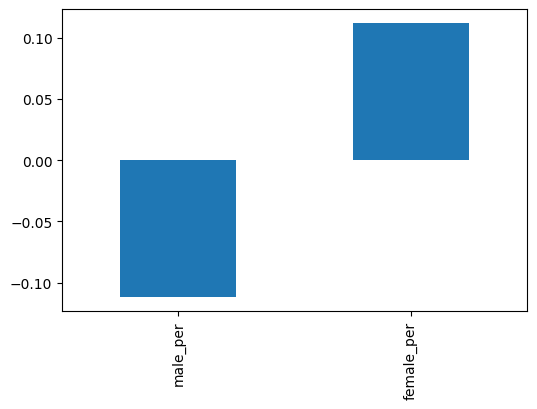

In [21]:
gen_cols = ['male_per', 'female_per']

combined.corr()["sat_score"][gen_cols].plot.bar()

This suggests that on schools with higher percentage of females tend to perform better in SATs compared to male dominated schools. 

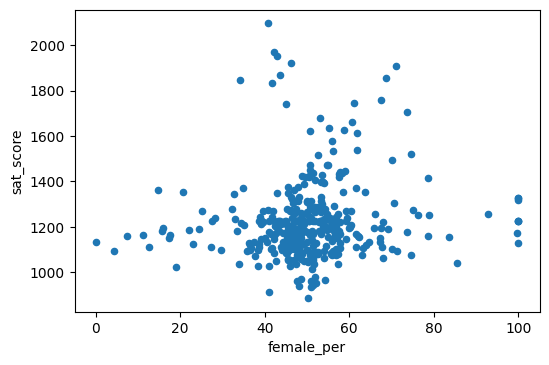

In [22]:
%matplotlib inline
combined.plot.scatter(x = 'female_per', y = 'sat_score')

Interestingly, it seems that schools that perform better are schools where the mix arent very extreme (i.e. full boys/girls schools)

In [23]:
mask_3 = (combined['female_per']>60)&(combined['sat_score']>1700)
combined[mask_3]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


These schools are very selective schools which involve an entrance exam/meeting a requirement to be accepted. 

Schools that test for intelligence are again more likley to achieve better SAT score.

# AP exams & SAT scores

In [24]:
#Percentage of students in school taking AP
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100

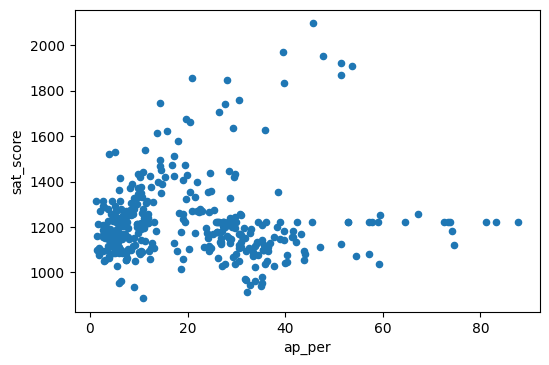

In [25]:
%matplotlib inline
combined.plot.scatter(x = 'ap_per', y = 'sat_score')

There does seem to be a slight positive correlation between percentage taking AP exam and the average SAT score of the school.

However it is a fairly weak correlation.